In [10]:
import pandas as pd
import numpy as np

In [11]:
df = pd.read_csv("../../data/final/Roommate_Compatibility_Survey.csv")
df.head()

,Gender,Parents_Abroad,Living_with_Parents,Attitude_towards_Roommate_Smoking,Preferred_Roommate_Relationship_Type,Description_of_Personal_Room_At_Home,Desired_Room_Attributes,Bedtime_Preference,Planned_Study_Time_Preference,Study_Time_Preference,...,Loud music/TV,Being loud when I’m studying/sleeping,Eating my food,Not picking up after themselves,Being unfriendly,Lack of respect for me and my privacy,Bad personal hygiene,Using my things without asking,Having guests over too much,Messy
0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.333333,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.666667,0.333333,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.666667,0.666667,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.666667,1.000000,0.5,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.5,0.0,1.0,0.0,0.666667,1.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


### Kmeans

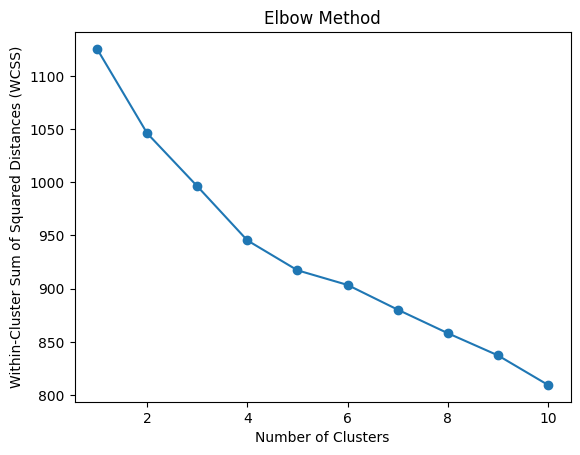

In [12]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Initialize an empty list to store the within-cluster sum of squared distances
wcss = []

# Try different values of k from 1 to 10
for i in range(1, 11):
    # Initialize KMeans with the current value of k
    kmeans = KMeans(n_clusters=i, random_state=42)
    
    # Fit KMeans to the data
    kmeans.fit(df)
    
    # Append the WCSS to the list
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squared Distances (WCSS)')
plt.show()


In [13]:
from sklearn.cluster import KMeans
from sklearn import metrics


k = 5

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df)
kMeans_labels = kmeans.labels_

cluster_centroids = kmeans.cluster_centers_

db_index = metrics.davies_bouldin_score(df, kMeans_labels)

silhouette_score = metrics.silhouette_score(df, kMeans_labels)

ch_score = metrics.calinski_harabasz_score(df, kMeans_labels)

print("Davies-Bouldin index:", db_index)
print("Silhouette coefficient:", silhouette_score)
print("Calinski-Harabasz index:", ch_score)


Davies-Bouldin index: 2.849962562259001
Silhouette coefficient: 0.06184291531498454
Calinski-Harabasz index: 14.235832069017253


### BIRCH

In [14]:
from sklearn.cluster import Birch
from sklearn import metrics

n_clusters = 5

birch = Birch(n_clusters=n_clusters)

birch.fit(df)

labels = birch.labels_
db_index = metrics.davies_bouldin_score(df, labels)
silhouette_score = metrics.silhouette_score(df, labels)
ch_score = metrics.calinski_harabasz_score(df, labels)

print("Davies-Bouldin index:", db_index)
print("Silhouette coefficient:", silhouette_score)
print("Calinski-Harabasz index:", ch_score)


Davies-Bouldin index: 3.0574118039941016
Silhouette coefficient: 0.041375121398328954
Calinski-Harabasz index: 11.879155870639444


### DBSCAN

In [15]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Define DBSCAN parameters
epsilon = 0.5  
min_samples = 2  

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)


labels = dbscan.fit_predict(df)
db_index = metrics.davies_bouldin_score(df, labels)
silhouette_score = metrics.silhouette_score(df, labels)

ch_score = metrics.calinski_harabasz_score(df, labels)

print("Davies-Bouldin index:", db_index)
print("Silhouette coefficient:", silhouette_score)
print("Calinski-Harabasz index:", ch_score)


Davies-Bouldin index: 0.9183585283491257
Silhouette coefficient: 0.03936546440732912
Calinski-Harabasz index: 2.336966979886457


In [16]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics

n_clusters = 5

gmm = GaussianMixture(n_components=n_clusters)
gmm.fit(df)

labels = gmm.predict(df)

db_index = metrics.davies_bouldin_score(df, labels)

silhouette_score = metrics.silhouette_score(df, labels)

ch_score = metrics.calinski_harabasz_score(df, labels)

print("Davies-Bouldin index:", db_index)
print("Silhouette coefficient:", silhouette_score)
print("Calinski-Harabasz index:", ch_score)


Davies-Bouldin index: 3.1076654337008227
Silhouette coefficient: 0.05001247827864817
Calinski-Harabasz index: 12.309925599271969


In [17]:
def calculate_similarity(cluster_centroids):
    n_clusters = len(cluster_centroids)
    similarities = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(i+1, n_clusters):
            dist = np.linalg.norm(cluster_centroids[i] - cluster_centroids[j])  # Euclidean distance
            similarities[i, j] = similarities[j, i] = 1 / (1 + dist)  # Similarity score (inverse of distance)
    return similarities

cluster_similarities = calculate_similarity(cluster_centroids)


In [20]:
df['cluster_label'] = labels

def intra_cluster_recommendations(user_index, df, limit=5):
    cluster_id = df.loc[user_index, 'cluster_label']
    cluster_users = df[df['cluster_label'] == cluster_id].index
    similar_users = cluster_users.drop(user_index)
    cluster_info = {
        'cluster_id': cluster_id,
        'cluster_size': len(cluster_users)
    }
    return similar_users[:limit], cluster_info

def inter_cluster_recommendations(user_index, df, cluster_similarities, limit=5):
    cluster_id = df.loc[user_index, 'cluster_label']
    similar_clusters = np.argsort(cluster_similarities[cluster_id])[::-1] 
    inter_recommendations = []
    for cluster in similar_clusters:
        cluster_users = df[df['cluster_label'] == cluster].index
        inter_recommendations.extend(cluster_users)
    return inter_recommendations[:limit]

user_index = 4  # Index of the user in the DataFrame
intra_cluster_recs, cluster_info = intra_cluster_recommendations(user_index, df, limit=5)
inter_cluster_recs = inter_cluster_recommendations(user_index, df, cluster_similarities, limit=5) 

print("Intra-cluster recommendations for user at index", user_index, ":", intra_cluster_recs)
print("Cluster information:", cluster_info)
print("Inter-cluster recommendations for user at index", user_index, ":", inter_cluster_recs) 


Intra-cluster recommendations for user at index 4 : Index([3, 6, 17, 22, 25], dtype='int64')
Cluster information: {'cluster_id': 3, 'cluster_size': 50}
Inter-cluster recommendations for user at index 4 : [8, 9, 12, 13, 14]
